# MDLE - Exercise 1.1
### Collaborative Filtering
##### Authors: Pedro Duarte 97673, Pedro Monteiro 97484

Import necessary modules

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import pandas as pd

import json

Declare constants

In [2]:
# Spark Constants
APP_NAME = 'assignment1'
MASTER = 'local[*]'

# Input Constants
INPUT_METADATA_FILE = 'tracks.csv'
INPUT_FEATURES_FILE = 'features.csv'

# Data Columns
COLUMN_TRACK_ID = 'track_id'
COLUMN_SUBSET = 'set_subset'

# Application Constants
SUBSET_SMALL_VALUE = 'small'

Configuration and Initialization of Spark

- Parameters:
    - `APP_NAME` (string): the name of the Spark application
    - `MASTER` (string): the URL of the Spark master node
<br></br>
- Returns:
    - `sc` (SparkContext): the Spark context for the given application and master
    - `spark` (SparkSession): the Spark session for the given application and master

In [3]:
conf = SparkConf().setAppName(APP_NAME).setMaster(MASTER)
sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession.builder.appName(APP_NAME).master(MASTER).getOrCreate()

23/04/25 15:18:27 WARN Utils: Your hostname, pedro-duarte resolves to a loopback address: 127.0.1.1; using 192.168.1.201 instead (on interface wlp2s0)
23/04/25 15:18:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/25 15:18:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
tracks = pd.read_csv(INPUT_METADATA_FILE, index_col=0, header=[0, 1])
features = pd.read_csv(INPUT_FEATURES_FILE, index_col=0, header=[0, 1, 2])

In [5]:
small = tracks[tracks['set', 'subset'] == 'small']
small.shape

(8000, 52)

In [6]:
ids = set(small.index.to_list())
features_sm = features.loc[ids]
features_sm.shape

/tmp/ipykernel_505321/1115158780.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  features_sm = features.loc[ids]


(8000, 518)

In [32]:
from sklearn.preprocessing import StandardScaler

X = features_sm.values
X = StandardScaler().fit(X).transform(X)

In [55]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import numpy as np
import math

results = {}

for k in range(8, 17):
    clusters = AgglomerativeClustering(n_clusters=k).fit_predict(X)

    clusters_separated = [X[clusters == i] for i in range(k)]
    centroids = [cluster.mean(axis=0) for cluster in clusters_separated]

    radius = [max(np.linalg.norm(p - centroids[i]) for p in clusters_separated[i]) for i in range(k)]
    diameter = [np.max(pairwise_distances(cluster)) for cluster in clusters_separated]

    # !! division by 0 !!
    density_r = [len(clusters_separated[i]) / (radius[i]**2) if radius[i] != 0 else math.inf for i in range(k)]
    density_d = [len(clusters_separated[i]) / (diameter[i]**2) if diameter[i] != 0 else math.inf for i in range(k)]

    results[k] = {
        'radius': radius,
        'diameter': diameter,
        'density_r': density_r,
        'density_d': density_d,
    }

    print(f'For k = {k}:')
    print('Radius:', radius)
    print('Diameter:', diameter)
    print('Density (r2):', density_r)
    print('Density (d2):', density_d)
    print()

For k = 8:
Radius: [131.9635070863535, 85.61707555250149, 57.70367758776073, 108.58973665171192, 56.55991248912924, 0.0, 69.26651356236508, 0.0]
Diameter: [173.98817814544742, 104.32765325996061, 78.29800458030583, 138.6511252678381, 80.15796245946396, 0.0, 86.41438670574432, 0.0]
Density (r2): [0.12604534947908394, 0.19426260600852557, 0.9247039305792399, 0.005681947844095345, 0.3622980347779691, inf, 0.015423575461012385, inf]
Density (d2): [0.07250952221003852, 0.13083113598178184, 0.502236533071095, 0.003485202408848669, 0.1803807122132652, inf, 0.009909679658004903, inf]

For k = 9:
Radius: [57.70367758776073, 85.61707555250149, 131.53468744381067, 108.58973665171192, 56.55991248912924, 0.0, 69.26651356236508, 0.0, 73.19915536057896]
Diameter: [78.29800458030583, 104.32765325996061, 173.98817814544742, 138.6511252678381, 80.15796245946396, 0.0, 86.41438670574432, 0.0, 93.5137932752037]
Density (r2): [0.9247039305792399, 0.19426260600852557, 0.05670069902810301, 0.00568194784409534

### 1.2

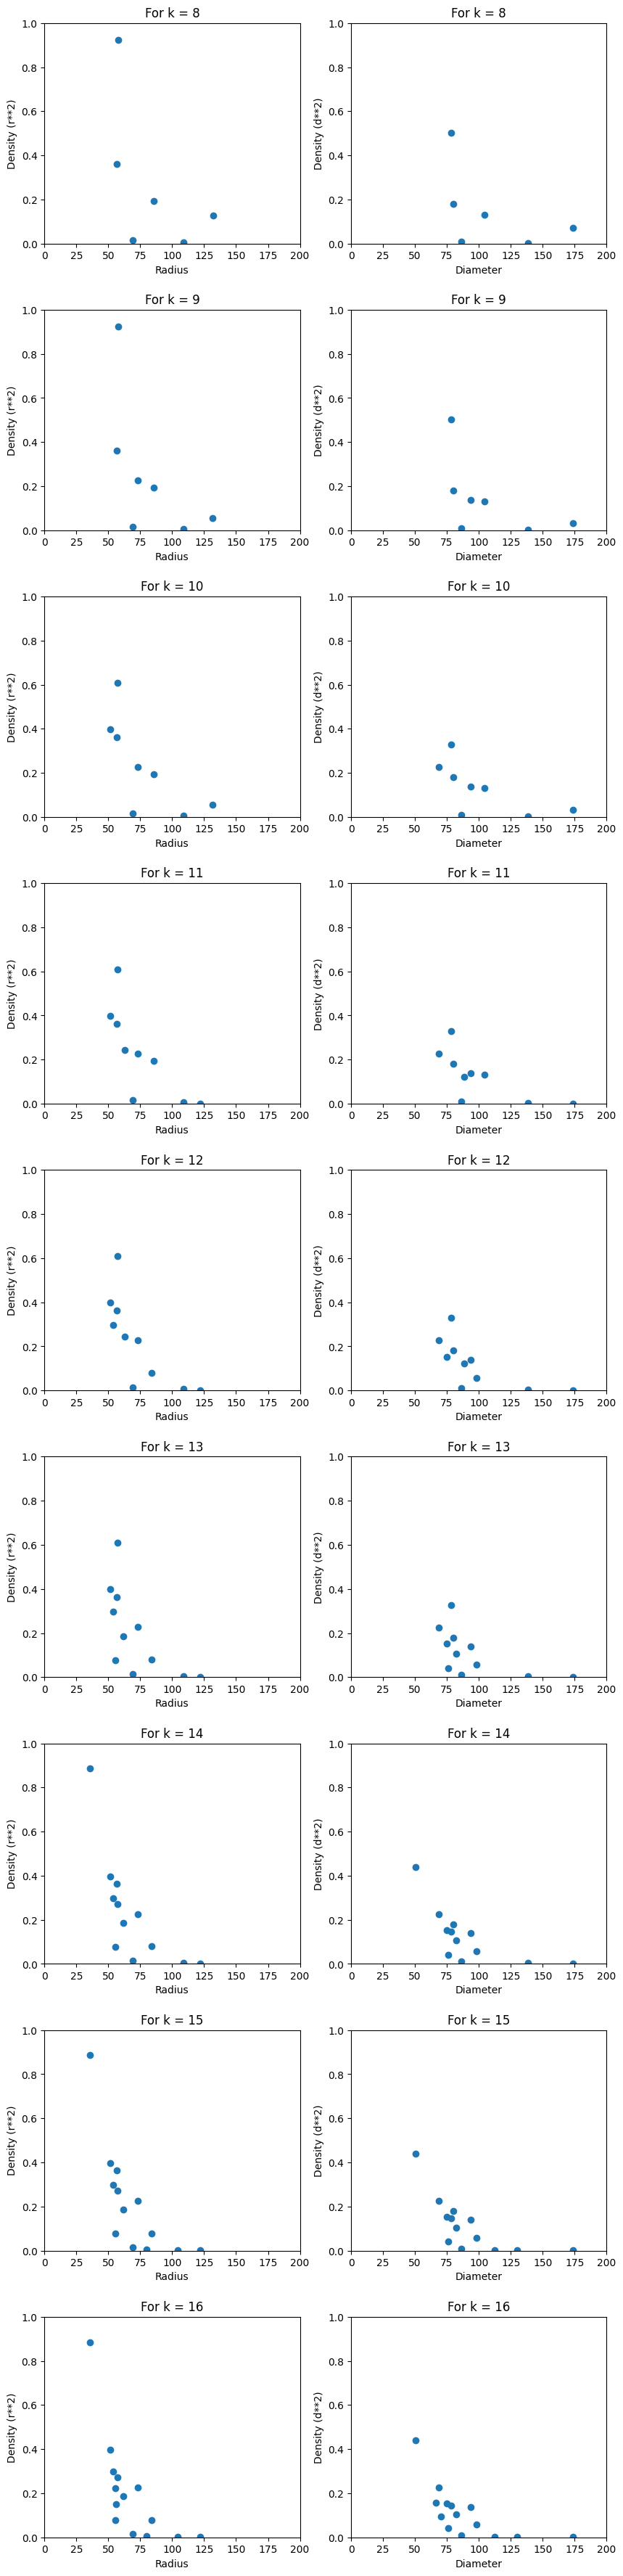

In [76]:
from matplotlib import pyplot as plt

ks = list(results.keys())
fig = plt.figure()

fig.set_figwidth(10)
fig.set_figheight(45)
fig.set_animated(True)
fig.subplots_adjust(hspace=.3)

for i in range(len(ks)):
  k = ks[i]

  sub_r = fig.add_subplot(len(ks), 2, 2*i+1)
  sub_r.scatter(results[k]['radius'], results[ks[i]]['density_r'])
  sub_r.set_xlabel('Radius')
  sub_r.set_ylabel('Density (r**2)')
  sub_r.set_title(f'For k = {k}')
  sub_r.set_xlim([0, 200])
  sub_r.set_ylim([0, 1])

  sub_d = fig.add_subplot(len(ks), 2, 2*i+2)
  sub_d.scatter(results[k]['diameter'], results[ks[i]]['density_d'])
  sub_d.set_xlabel('Diameter')
  sub_d.set_ylabel('Density (d**2)')
  sub_d.set_title(f'For k = {k}')
  sub_d.set_xlim([0, 200])
  sub_d.set_ylim([0, 1])

plt.show()